In [1]:
import Pkg
Pkg.activate(".")
using Lux, Metal, MLUtils, MultivariateStats, Optimisers, Random, Zygote, LossFunctions
using CairoMakie, Printf, Statistics, LinearAlgebra, HDF5

  Activating project at `~/Dropbox/research/sciml-tearfilms/julia`


Load synthetic data from files.

In [2]:
function load_data(files)
    function getmats(file)
        datastore = h5open(file, "r")
        I = read(datastore["I"])
        T = read(datastore["T"])
        c = read(datastore["c"])
        close(datastore)
        return I, T, c
    end
    mats = map(getmats, files)
    I = hcat([m[1] for m in mats]...)
    T = hcat([m[2] for m in mats]...)
    c = hcat([m[3] for m in mats]...)
    t = range(0, 1, size(I, 1))
    return t, (; I, T, c)
end

t, data = load_data(["/Users/driscoll/Dropbox/research/tearfilm/thermal/inverse/trials_many_alldata_v3.h5"]);
println("$(size(data.I, 2)) samples loaded");

111563 samples loaded


Examples of inputs and outputs:

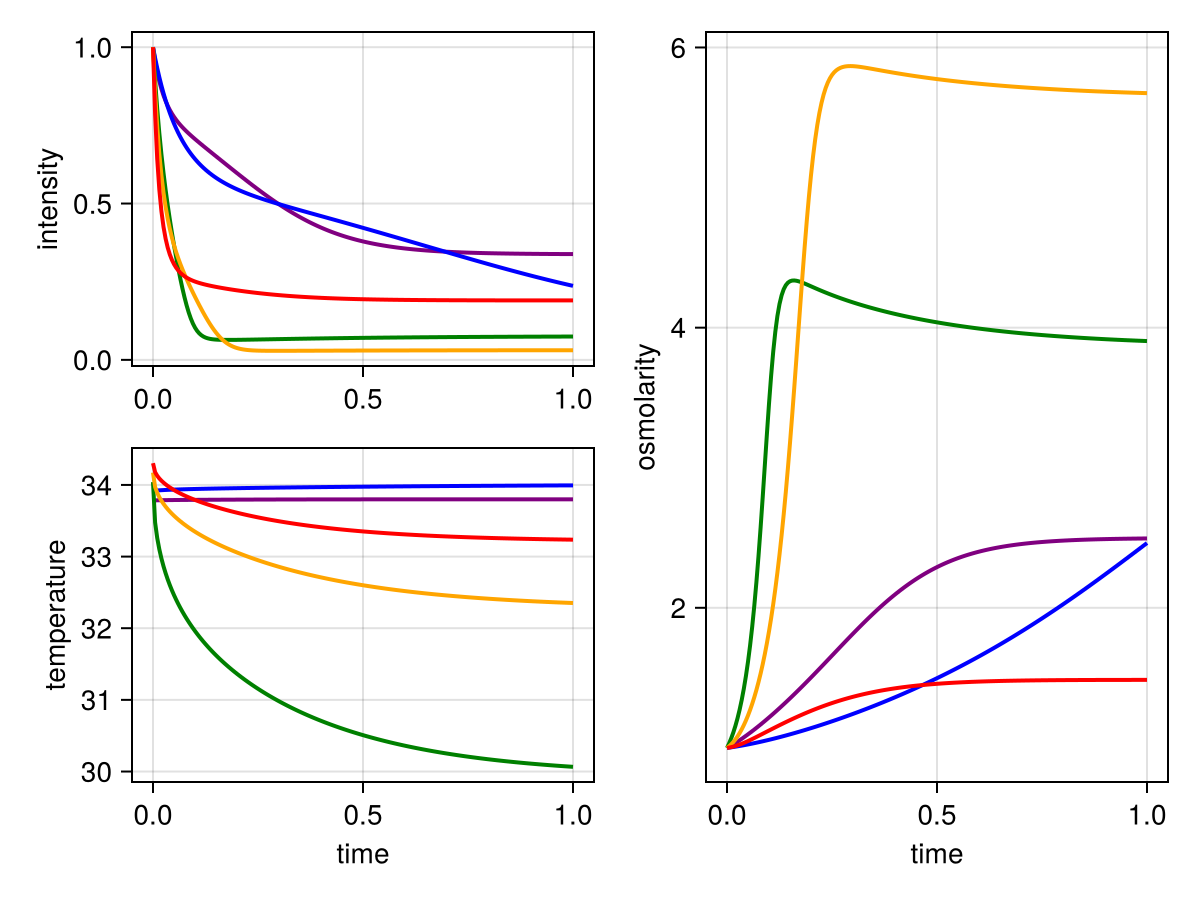

In [22]:
fig = Figure()
fig[1,1] = gr = GridLayout()
series(gr[1,1], t, data.I[:,1:5]', axis=(ylabel="intensity", ), color=:rainbow)
series(gr[2,1], t, data.T[:,1:5]', axis=(xlabel="time", ylabel="temperature"), color=:rainbow)
series(fig[1,2], t, data.c[:,1:5]', axis=(xlabel="time", ylabel="osmolarity"), color=:rainbow)
fig

Apply PCA to the input data and prepare for batch training.

In [33]:
function convert_data(data, batchsize, train_split=0.8, n_comp=20)
    pcaI = fit(PCA, data.I, maxoutdim=n_comp, pratio=0.9999);
    pcaT = fit(PCA, data.T, maxoutdim=n_comp, pratio=0.9999);
    pcac = fit(PCA, data.c, maxoutdim=n_comp, pratio=0.9999);

    X = [predict(pcaI, data.I); predict(pcaT, data.T)];
    y = predict(pcac, data.c)
    idx_train, idx_test = splitobs(axes(X, 2); at=train_split)
    # (X_train, y_train), (X_test, y_test) = splitobs((X, y); at=train_split)
    return idx_train, idx_test, (; I = pcaI, T = pcaT, c=pcac),
        DataLoader(collect.((X[:, idx_train], y[:, idx_train])); batchsize, shuffle=true),
        DataLoader(collect.((X[:, idx_test], y[:, idx_test])); batchsize, shuffle=false)
end

idx_train, idx_test, pca, train_loader, test_loader = convert_data(data, 1000);
dim_input = size(train_loader.data[1], 1)
dim_output = size(train_loader.data[2], 1)
println("input data has dimension $(dim_input)")
println("output data has dimension $(dim_output)")

input data has dimension 12
output data has dimension 13


Define a training loop.

In [5]:
function train(loss, model, ps, st, train_loader, test_loader; num_epochs=10, rate=0.005, kwargs...)
    train_state = Training.TrainState(model, ps, st, Adam(Float32(rate)))

    ### Warm up the model
    x, y = first(train_loader)
    Training.compute_gradients(AutoZygote(), loss, (x, y), train_state)

    ### Train the model
    tr_acc, te_acc = 0.0, 0.0
    for epoch in 1:num_epochs
        stime = time()
        for (x, y) in train_loader
            gs, _, _, train_state = Training.single_train_step!(
                AutoZygote(), loss, (x, y), train_state)
        end
        ttime = time() - stime

        tr_acc = accuracy(loss,
            model, train_state.parameters, train_state.states, train_loader)
        te_acc = accuracy(loss,
            model, train_state.parameters, train_state.states, test_loader)

        # @printf "[%2d/%2d] \t Time %.2fs \t Training loss: %.4g \t Test loss: \
                #  %.4g\n" epoch num_epochs ttime tr_acc te_acc
    end

    return tr_acc, te_acc
end

function accuracy(loss, model, ps, st, dataloader)
    tse, total = 0, 0
    st = Lux.testmode(st)
    for (x, y) in dataloader
        predicted = first(model(x, ps, st))
        n = size(x, 2)
        tse += n*loss(predicted, y)
        total += n
    end
    return tse / total
end

accuracy (generic function with 1 method)

Create a NN model.

In [42]:
model = Chain(
    Dense(dim_input => 256, relu),
    Dense(256 => 256, relu),
    # Dense(256 => 256, relu),
    Dense(256 => dim_output),
)

# initialize the model parameters 
ps, st = Lux.setup(Xoshiro(0), model)

loss = MSELoss();

Run training.

In [47]:
train_acc, test_acc = train(loss, model, ps, st, train_loader, test_loader; num_epochs=100, rate=0.0005)


(0.90640295f0, 0.95533913f0)

Find predictions over all the test data.

In [48]:
c_pred = hcat([reconstruct(pca.c, first(model(x, ps, st))) for (x, _) in test_loader]...);
# c_true = hcat([y for (_, y) in test_loader]...);
c_true = data.c[:, idx_test];

Look at a few comparisons.

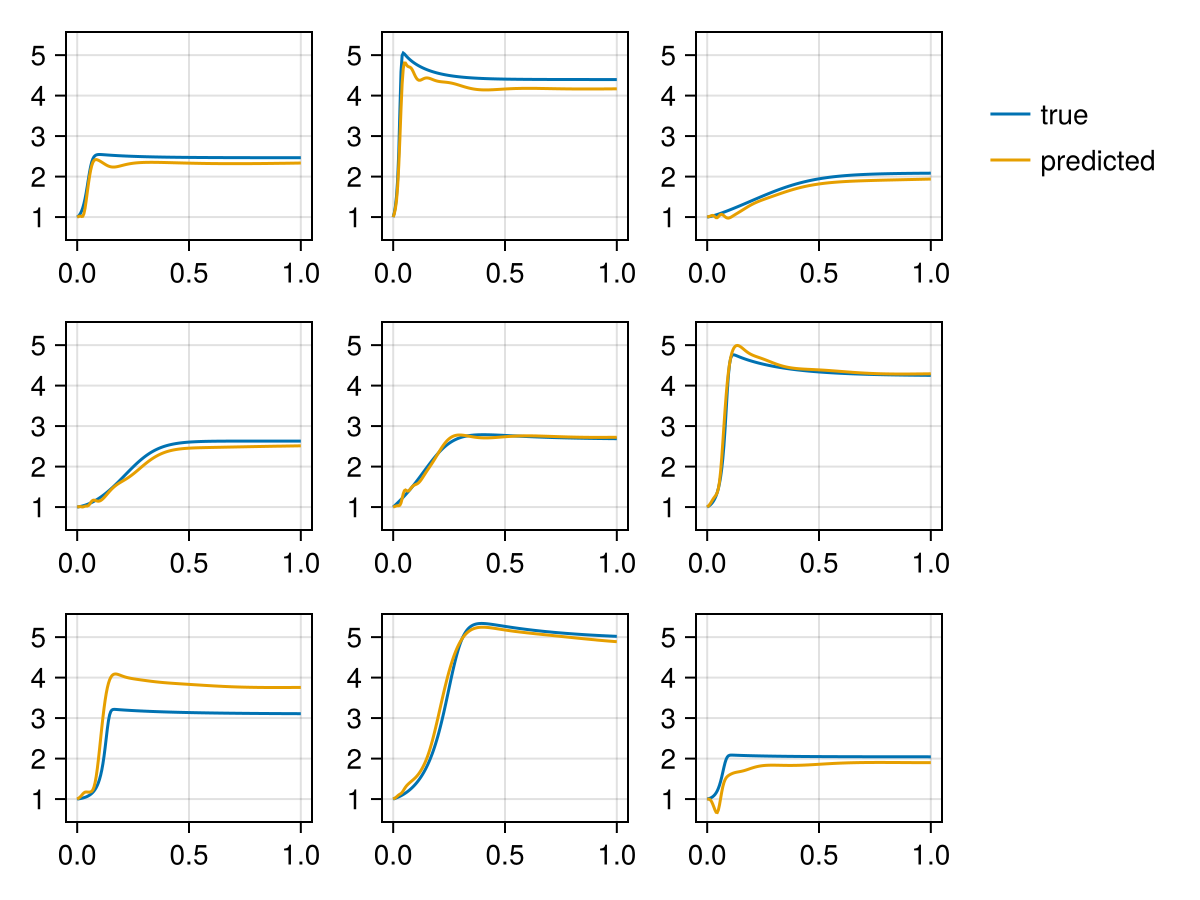

In [63]:
fig = Figure()
grid = CartesianIndices((1:3, 1:3))
norm_diff = map(norm, eachcol(c_pred - c_true)) ./ map(norm, eachcol(c_true))
worst = sortperm(norm_diff, rev=true)[1:9]
worst = first(shuffle(eachindex(norm_diff)), 9)
for (k, idx) in enumerate(grid)
    lines(fig[idx[1],idx[2]], t, c_true[:, worst[k]], label="true")
    lines!(t, c_pred[:, worst[k]], label="predicted")
    # current_axis().title = "err = $(round(log10(norm_diff[worst[k]]),digits=3))"
end
linkyaxes!(fig.content...)
Legend(fig[1, 4], fig.content[1], framevisible=false)
fig

In [64]:
save("operator_osmo.pdf", fig)

CairoMakie.Screen{PDF}


Find the L2-norms of the differences.

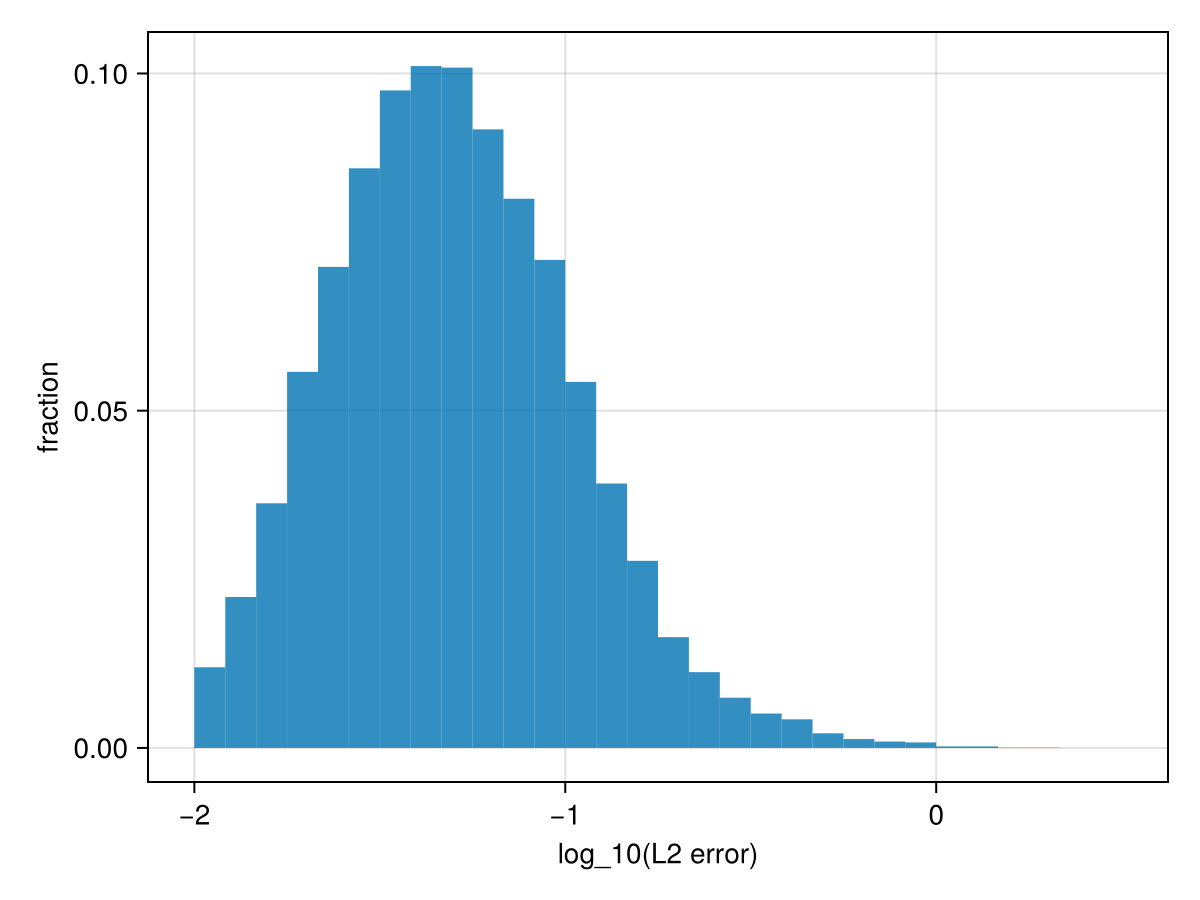

In [52]:
norm_diff = map(norm, eachcol(c_pred - c_true)) ./ map(norm, eachcol(c_true))
fig, ax, _ = hist(log10.(norm_diff), bins=range(-2, 0.5, 31), normalization=:probability)
ax.xlabel = "log_10(L2 error)"
ax.ylabel = "fraction"
fig